## Kuramoto-Sivashinsky: Two-step Method

In [31]:
import sys
#sys.path.append('/Users/josorior/Documents/UW/research/keql/KEQL/source')
#sys.path.append('/Users/yasaminjalalian/Repos/KEQL/source')
sys.path.append('/home/juanfelipe/Desktop/research/keql/source')

In [32]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import * 
from models import *
from data_loader import * 
import pysindy as ps
from scipy.io import loadmat

from jax.config import config; 
config.update("jax_enable_x64", True)

In [33]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [34]:
model = 'pendulum'

In [35]:
# 2-step dictionary
keys = ['optim_sgm_u','optim_nugget_u','rkhs_u','optim_sgm_P','optim_nugget_P','nugget_P', 'rkhs_P','f_pred_test']
two_step_dict = dict.fromkeys(keys)

### Solution: Two-Step Method

In [36]:
data = loadmat('/home/juanfelipe/Desktop/research/keql/examples/KS/data/kuramoto_sivishinky.mat')

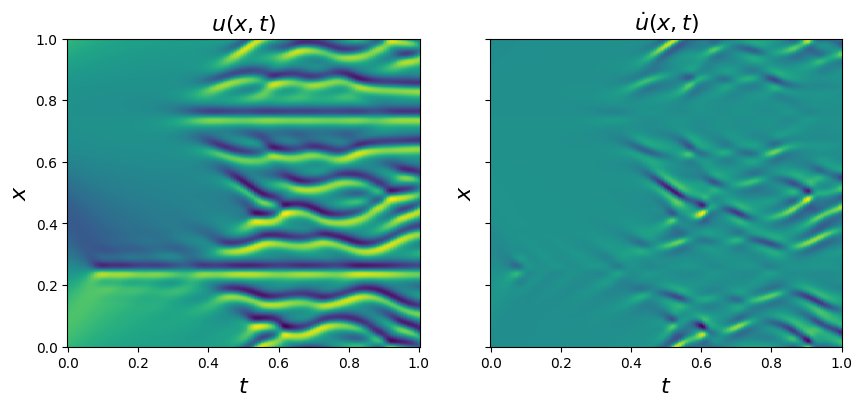

In [37]:
# t scaler
t_scaler = MinMaxScaler()
t = data['tt'].T
t = np.ravel(t_scaler.fit_transform(t))
dt = t[1] - t[0]
# x scaler
x_scaler = MinMaxScaler()
x = data['x']
x = np.ravel(x_scaler.fit_transform(x))
# u scaler
u_scaler = MinMaxScaler()
u = data['uu'].reshape(-1,1)
u = u_scaler.fit_transform(u)
u = u.reshape(1024, 251)

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, u)
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$x$', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)

u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, u_dot)
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$x$', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()
#u = u.reshape(len(x), len(t), 1)

> Step 1: Learning $u's$

In [38]:
T, X = np.meshgrid(t,x)
# N x 2 of all collocation points 
all_pairs = np.vstack([T.ravel(), X.ravel()]) 
# N values of u at all collocation points 
u_all_flat = u.flatten() 
# N values of u_dot at all collocation points
u_dot_all_flat = u_dot.flatten()
# Sample
all_ = np.vstack([all_pairs,u_all_flat]).T # N x 3 of collocation pts and u values 
dot_all_ = np.vstack([all_pairs,u_dot_all_flat]).T # N x 3 of collocation pts and u_dot values
idx_train = np.random.randint(len(all_), size = int(1e3))
idx_test = np.random.randint(len(all_), size = int(1e4))
# idx_test = np.ones(len(all_), dtype=bool)
# idx_test[idx_train] = False
train_ = all_[idx_train,:]
test_ = all_[idx_test,:]
dot_train_ = dot_all_[idx_train,:]
dot_test_ = dot_all_[idx_test,:]
x_train, t_train, u_train = train_[:,0], train_[:,1], train_[:,2]
x_train, t_train, u_t_train = dot_train_[:,0], dot_train_[:,1], dot_train_[:,2]
x_test, t_test, u_test, u_t_test = test_[:,0], test_[:,1], test_[:,2], dot_test_[:,2]
e, e_test = len(u_train), len(u_test)
X_train = np.vstack([x_train,t_train]).T
X_test = np.vstack([x_test,t_test]).T

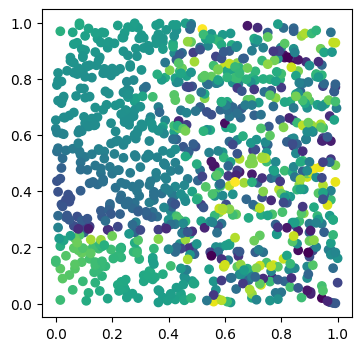

In [39]:
plt.figure(figsize=(4, 4))
plt.scatter(x_train, t_train, c = u_train)

In [40]:
optim_rho_u, alphas, optim_nugget_u = kernel_parameters_Matern52_2D(X_train, u_train.reshape(-1,1), e)

In [41]:
# Save true values to be used in one-step
two_step_dict['optim_rho_u'] = optim_rho_u 
two_step_dict['optim_nugget_u'] = optim_nugget_u
optim_rho_u, optim_nugget_u

(array([1.01935507]), array([1.e-08]))

In [42]:
u_pred_train, u_x_pred_train, u_t_pred_train , u_xx_pred_train , u_xxxx_pred_train = predictions_KS(X_train, X_train, Matern_Kernel_52_2D, optim_rho_u, alphas, e , e)
u_pred_test, u_x_pred_test, u_t_pred_test , u_xx_pred_test , u_xxxx_pred_test  = predictions_KS(X_test,  X_train, Matern_Kernel_52_2D, optim_rho_u, alphas, e, e_test)

In [43]:
# # Save true values to warm up the onepfive method
# np.save('data/u_pred_train.npy', u_pred_train)
# np.save('data/u_pred_test.npy', u_pred_test)
# # Save true gradients for comparing later
# np.save('data/u_x_train.npy',u_x_train)
# np.save('data/u_xx_train.npy',u_xx_train)
# # Save gradients for one step method
# np.save('data/u_x_pred_train.npy',u_x_pred_train)
# np.save('data/u_xx_pred_train.npy',u_xx_pred_train)
# np.save('data/u_x_pred_test.npy',u_x_pred_test)
# np.save('data/u_xx_pred_test.npy',u_xx_pred_test)

Text(0.5, 1.0, 'u_true')

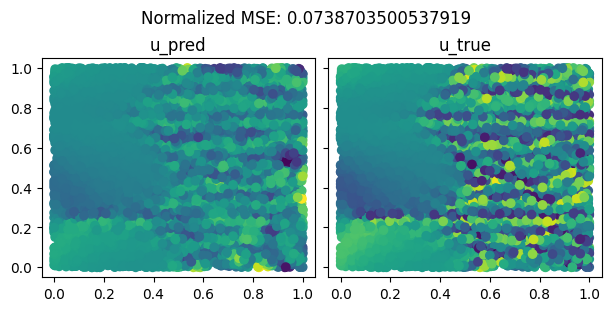

In [44]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2 ,sharey= True, figsize = (6,3),constrained_layout=True)
n_mse = mean_squared_error(u_pred_test, u_test)/mean_squared_error(u_pred_test*0, u_test)
fig.suptitle('Normalized MSE: {}'.format(round(n_mse,16)))
ax1.scatter(x_test, t_test, c = u_pred_test)
ax1.set_title('u_pred')
ax2.scatter(x_test, t_test, c = u_test)
ax2.set_title('u_true')

In [50]:
u_t_pred_test = np.nan_to_num(u_t_pred_test)

Text(0.5, 1.0, 'u_t_true_test')

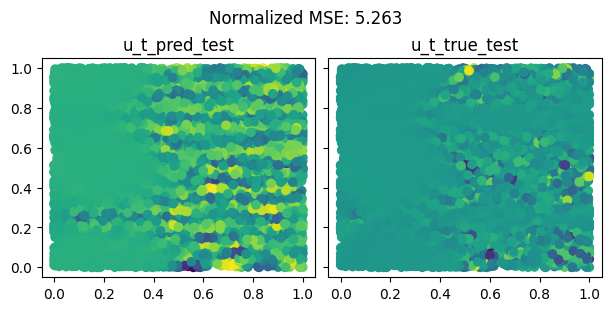

In [51]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2 ,sharey= True, figsize = (6,3),constrained_layout=True)
n_mse = mean_squared_error(u_t_pred_test, u_t_test)/mean_squared_error(u_t_pred_test*0, u_t_test)
fig.suptitle('Normalized MSE: {}'.format(round(n_mse,3)))
ax1.scatter(x_test, t_test, c = u_t_pred_test)
ax1.set_title('u_t_pred_test')
ax2.scatter(x_test, t_test, c = u_t_test)
ax2.set_title('u_t_true_test')
# comment

RKHSs norms squared $u^*$

In [30]:
K_2dot2D(Matern_Kernel_52_2D, X_train, X_train, optim_rho_u[0],0,0)

Array([[-1.08097057, -0.81662148, -0.88359108, ..., -1.48531448,
        -0.54976621, -0.62679576],
       [-1.01310608, -0.91860055, -1.2320432 , ..., -0.89922138,
        -0.78584637, -0.30776926],
       [-1.29736922, -0.12682756, -0.13883395, ..., -0.85081046,
         0.01910942, -1.36203365],
       ...,
       [-0.93928378,  0.06375822,  0.0138025 , ..., -0.80344997,
         0.1876224 , -1.53490599],
       [-1.38776149, -0.5893402 , -0.69163701, ..., -1.31287465,
        -0.36278886, -0.85038553],
       [-1.42072424, -0.21614578, -0.25081727, ..., -0.85582913,
        -0.06783553, -1.2075463 ]], dtype=float64)

In [ ]:
rkhs_u = []
G = K_2D(Matern_Kernel_52_2D, X_train, X_train, optim_rho_u)
# G = G + 1e-5*jnp.diag(jnp.diag(G)) # I had to regularize here (?)
alphas = np.linalg.solve(G, u_pred_train.flatten())
rkhs_u.append(np.dot(u_pred_train.flatten(),alphas))
# Print the norm
print('RKHS^2 norm of u^*: {}'.format(round(rkhs_u[0],2)))
# Save true values to be used in 1-step
two_step_dict['rkhs_u'] = rkhs_u

We compute the norm of $u_*$ since it is more regular than $u$.

> Step 2: Learning $P$

In [27]:
s_train = np.hstack((X_train,u_train.T.reshape(-1,1),u_x_pred_train.T.reshape(-1,1))) # 30 * 5
s_test = s_train
#s_test = np.hstack((x_test_all.reshape(-1,1),u_pred_test.T.reshape(-1,1),u_x_pred_test.T.reshape(-1,1),u_xx_pred_test.T.reshape(-1,1)))  # 30 * 4
#f_train = f_Train(model)
f_train = u_t_pred_train.T.reshape(-1,1)
f_test = f_train
#f_test = f_Test(model,e_test)
scaler_s_train = MinMaxScaler()
s_train_s = scaler_s_train.fit_transform(s_train)
s_test_s = scaler_s_train.transform(s_test)

In [28]:
optim_sgm_P, optim_nugget_P = grid_search_RBF(s_train_s,f_train)

# Save true values to be used in one-step
two_step_dict['optim_sgm_P'] = optim_sgm_P
two_step_dict['optim_nugget_P'] = optim_nugget_P

krr_optimal_P = KernelRidge(kernel='rbf', alpha = optim_nugget_P, gamma=1/(2*(optim_sgm_P**2))) 
krr_optimal_P.fit(s_train_s, f_train) 
f_pred_train = krr_optimal_P.predict(s_train_s) 
f_pred_test = krr_optimal_P.predict(s_test_s)

In [15]:
print('Bandwith of P^*:{}  Nugget of P^*: {:.2e}'.format(round(optim_sgm_P,3),optim_nugget_P))

Bandwith of P^*:0.815  Nugget of P^*: 1.00e-08


Text(0.5, 1.0, 'f_true_train')

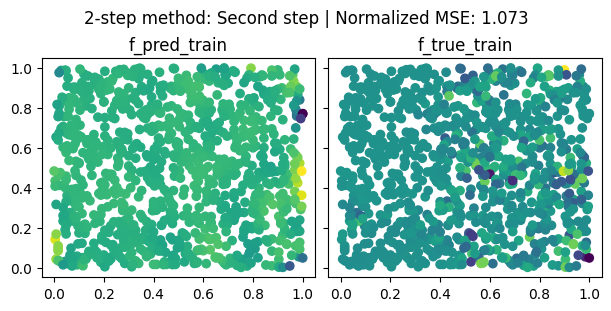

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2 ,sharey= True, figsize = (6,3),constrained_layout=True)
n_mse = mean_squared_error(f_pred_train, u_t_train)/mean_squared_error(f_pred_train*0, u_t_train)
fig.suptitle('2-step method: Second step | Normalized MSE: {}'.format(round(n_mse,3)))
ax1.scatter(x_train, t_train, c = f_pred_train)
ax1.set_title('f_pred_train')
ax2.scatter(x_train, t_train, c = u_t_train)
ax2.set_title('f_true_train')

RKHS norm squared of $P^*$

In [18]:
# rkhs_P
nugget_P = 1e-7
G = K(Gaussian,s_train_s,s_train_s, optim_sgm_P) + nugget_P*np.eye(x_train.size) # added nugget here !
alphas_P = np.linalg.solve(G, f_pred_train)
rkhs_P = np.dot(f_pred_train,alphas_P)
print('RKHS^s norm of P^*: {}'.format(round(rkhs_P,2)))
# Save true values to be used in one-step
two_step_dict['rkhs_P'] = rkhs_P
two_step_dict['nugget_P'] = nugget_P

RKHS^s norm of P^*: 4038.9


In [19]:
# rkhs_P
nugget_P = 1e-7
G_test = K(Gaussian,s_test_s,s_test_s, optim_sgm_P) + nugget_P*np.eye(x_test.size) # added nugget here !
alphas_P_test = np.linalg.solve(G_test, f_pred_test)
rkhs_P_test = np.dot(f_pred_test,alphas_P_test)
print('RKHS^s norm of P^*: {}'.format(round(rkhs_P_test,2)))

RKHS^s norm of P^*: 4038.9


In [20]:
two_step_dict['f_pred_test'] = f_pred_test

Test

> Compute std of feature 1 $\sigma_{\text{s[:,1]}}$ of `s_train` and perturb feature 1 of `s_train` using $m \sigma_{\text{s[:,1]}}$ each element. $m \in (0.01,0.25)$.

100%|██████████| 5/5 [26:15<00:00, 315.10s/it]

[[0.30727993 0.3050641  0.2885457  0.51013681 0.79423204 0.41325149
  1.         0.39036376 0.98746251 0.40710987 1.         0.59360873
  0.94266459]
 [0.30727993 0.33722375 0.35063813 0.32375788 0.93078591 0.39707048
  0.39323253 0.32091598 0.97720464 1.         1.         1.
  0.42367987]
 [0.30727993 0.2961042  0.28178207 0.3193984  0.39498787 0.94373808
  0.34195873 0.35719948 0.45963877 0.98650573 0.48604069 1.
  1.        ]
 [0.30727993 0.30677019 0.42758127 0.26635028 0.27646377 0.78506115
  0.20752729 0.30331942 0.94757542 0.95296983 1.         1.
  0.99823277]
 [0.30727993 0.30538129 0.2889236  0.49172536 0.34692223 0.41988716
  0.99160895 0.86969185 0.60998713 0.36611525 0.58579217 0.95386336
  0.37916941]]


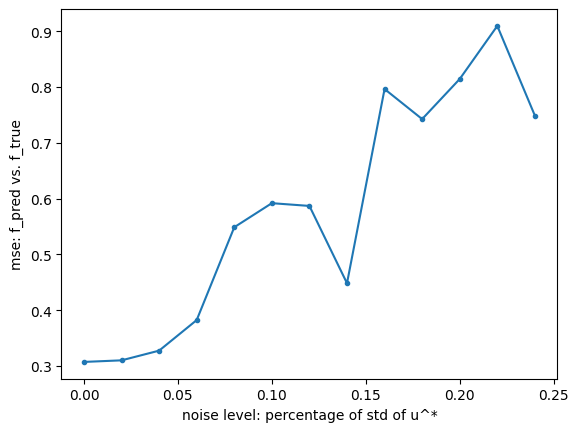

In [21]:
mses_P_all = []
for j in tqdm(range(5)):
    # Compute std per feature of s_train_s
    stds = np.std(s_train, axis = 0)
    beta = np.arange(0.0,0.25,0.02)
    scales = np.outer(beta, stds) 
    mses_P = []
    for i in tqdm(range(len(scales))):
        # Scales for current iteration
        scale = scales[i,:]
        # Copy s_train
        s_test = np.copy(s_train)
        # Perturb feature that contains u^* - Do this 10 times and average !!!
        s_test[:,1] = np.random.normal(s_train[:,1] , scale = scale[1])
        # Apply step one to perturbed u's 
        optim_sgm, alphas, optim_lmbd = kernel_parameters(x_train.reshape(-1,1), s_test[:,1].reshape(3,3).T, e)
        _, u_x_pred, u_xx_pred = predictions_ode(x_train, x_train, Gaussian, optim_sgm, alphas, e , e)
        s_test[:,2] = u_x_pred.T.reshape(-1,1).flatten()
        s_test[:,3] = u_xx_pred.T.reshape(-1,1).flatten()
        # Scale the new s_test
        s_test_s = scaler_s_train.transform(s_test)
        # Compute predictions on test
        f_pred_test = krr_optimal_P.predict(s_test_s)
        # True test -> Why if I use this rule for s_test_s the bellow rule cannot be compared with f_pred_test
        f_true_test = f_true_Test(model, s_test)
        # Compute mse per scale 
        mses_P.append(mean_squared_error(f_true_test,f_pred_test)/mean_squared_error(0*f_true_test,f_true_test))
# Plot - We have a vector of dimension 4 of scales vs. mses
    mses_P_all.append(mses_P)
mses_P_all = np.array(mses_P_all)
print(mses_P_all)
mean_mses_P_all = np.mean(mses_P_all, axis = 0)
plt.plot(beta,mean_mses_P_all,'.-')
plt.xlabel('noise level: percentage of std of u^*')
plt.ylabel('mse: f_pred vs. f_true')
plt.show()

In [23]:
np.save('data/two_step_dict.npy',two_step_dict)